In [1]:
#Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
# from sklearn.decomposition import PCA # 本次用不到
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier
from xgboost.sklearn import XGBClassifier

In [2]:
#Libraries
import pandas as pd
pd.set_option("display.max_columns", 101)

# Dataset is already loaded below
data = pd.read_csv("Train.csv")

# 幫欄位分類 (數值/類別)
ignore = ['id']
cat_feature = [
    'Term', 'State', 'Income Verification Status',
    'Home Ownership', 'Loan Purpose', 'Due Settlement',
    'Payment Plan'
]
num_feature = [x for x in data.columns if x not in cat_feature and x not in ignore]

#Description, 觀察後發現，有一些缺失值要處理
print(data.describe())
print(data.info())

print('= = = = =  After Imputer = = = =  =')

# 填值
imp_cat = SimpleImputer(strategy='most_frequent')
imp_num = SimpleImputer(strategy='median')
imp_cat_train = pd.DataFrame(imp_cat.fit(data[cat_feature]).transform(data[cat_feature]), columns=cat_feature)
imp_num_train = pd.DataFrame(imp_num.fit(data[num_feature]).transform(data[num_feature]), columns=num_feature)

data = (pd.concat([imp_cat_train, imp_num_train], axis=1, sort=True))
print(data.describe())
print(data.info())
print(data.columns)

## 可以跟Label Encode後的數值對照一下，方便後面EDA觀察
print(data['State'].unique())
print(data['Loan Purpose'].unique())

# # 幫類別資料編碼，移到EDA後面再做，圖片X軸比較清楚
# ## Label Encode
# le = LabelEncoder()
# for i in cat_feature:
#     data[i] = le.fit_transform(data[i])

data.head(10)

                id   Loan Amount  Annual Income  Average Account Balance  \
count  1894.000000   1800.000000    1822.000000              1788.000000   
mean   1273.117212  14999.013889   77178.816120             12672.040268   
std     740.130069   9275.904382   50209.852895             15373.593687   
min       0.000000   1000.000000    1000.000000                17.000000   
25%     629.250000   8000.000000   47218.750000              2936.750000   
50%    1289.500000  12775.000000   65900.000000              6463.000000   
75%    1910.750000  20000.000000   90000.000000             17959.000000   
max    2565.000000  40000.000000  575000.000000            196292.000000   

         Due Amount  Installment Amount  Approve Loan  
count   1853.000000         1878.000000   1894.000000  
mean    2245.644058          479.828408      0.563886  
std     5058.409367          299.898845      0.496033  
min        0.000000           30.120000      0.000000  
25%      220.140000          259.99

,Term,State,Income Verification Status,Home Ownership,Loan Purpose,Due Settlement,Payment Plan,Loan Amount,Annual Income,Average Account Balance,Due Amount,Installment Amount,Approve Loan
0,36 months,CO,Partially Verified,OWN,credit_card,N,n,25000.0,50000.0,4073.0,783.30,783.30,1.0
1,36 months,FL,Partially Verified,RENT,debt_consolidation,Y,n,8000.0,65000.0,2298.0,263.78,263.78,1.0
2,36 months,MI,Verified,MORTGAGE,debt_consolidation,N,n,11000.0,49000.0,1441.0,3978.72,342.12,1.0
3,36 months,CA,Verified,MORTGAGE,credit_card,Y,n,35000.0,108000.0,33603.0,1154.00,1154.00,1.0
4,36 months,CA,Partially Verified,RENT,debt_consolidation,Y,n,35000.0,87000.0,3399.0,1300.55,1300.55,0.0
5,36 months,CT,Verified,RENT,debt_consolidation,N,n,9500.0,37550.0,5565.0,313.01,313.01,1.0
6,60 months,MD,Verified,RENT,debt_consolidation,N,n,20000.0,90000.0,42842.0,97.44,592.79,0.0
7,36 months,IN,Not Verified,MORTGAGE,other,Y,n,12775.0,105000.0,26308.0,48.75,48.75,1.0
8,36 months,PA,Not Verified,RENT,debt_consolidation,Y,n,4500.0,60000.0,1490.0,141.52,141.52,1.0
9,36 months,TX,Not Verified,OWN,other,N,n,3300.0,150000.0,5930.0,1346.51,108.73,1.0


--- Approved Loan ----
        Loan Amount  Annual Income  Average Account Balance    Due Amount  \
count   1068.000000    1068.000000              1068.000000   1068.000000   
mean   13430.079588   83543.363642             13544.646067   2477.766526   
std     8815.971906   54339.624281             16088.153971   5161.411549   
min     1000.000000    1000.000000               274.000000      2.110000   
25%     7000.000000   52000.000000              3339.250000    200.000000   
50%    12000.000000   70000.000000              6643.500000    458.470000   
75%    17000.000000   99000.000000             19025.750000   1311.500000   
max    40000.000000  575000.000000            196292.000000  40471.140000   

       Installment Amount  Approve Loan  
count         1068.000000        1068.0  
mean           415.994588           1.0  
std            274.672600           0.0  
min             30.120000           1.0  
25%            207.922500           1.0  
50%            329.720000      

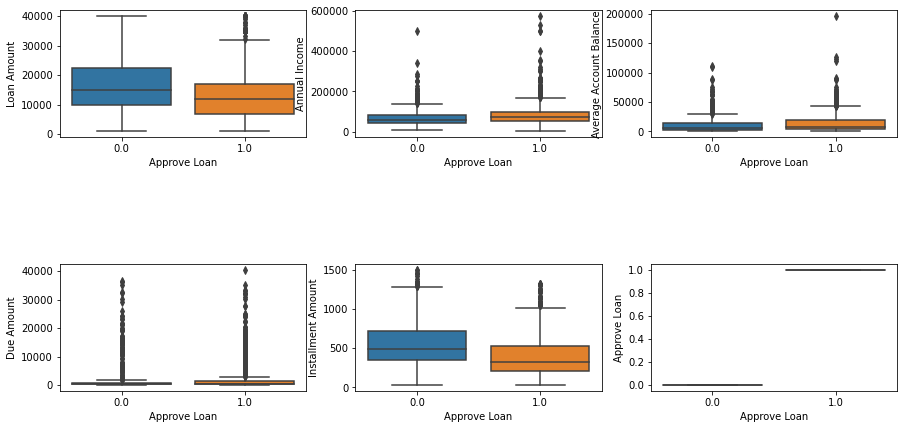

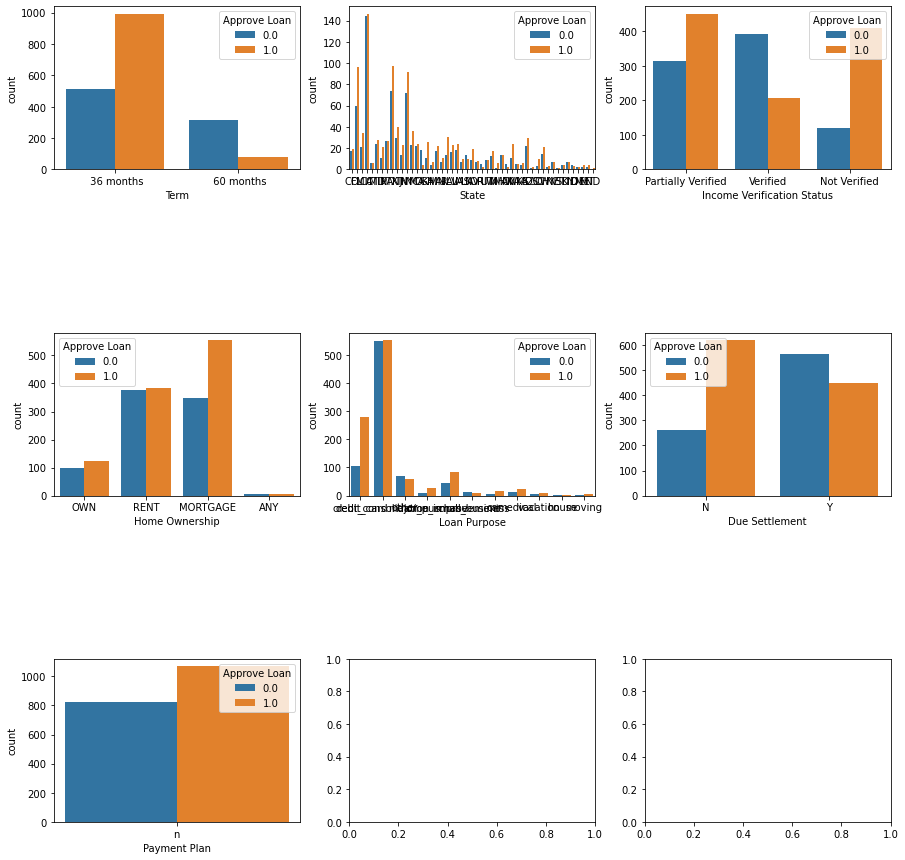

In [3]:
# EDA 觀察資料

## 數值資料們
### IDE的奇怪BUG，畫不出關聯矩陣
# fig = px.scatter_matrix(
#     data, 
#     dimensions=num_feature,
#     color="Approve Loan"
# )
# fig.show()

fig, axes = plt.subplots(2, 3, figsize=(15, 7))
for idx, cat_col in enumerate(num_feature):
    row, col = idx // 3, idx % 3
    sns.boxplot(y=cat_col, data=data, x='Approve Loan', ax=axes[row, col])
plt.subplots_adjust(hspace=1)
print('--- Approved Loan ----')
print(data[data['Approve Loan'] > 0].describe())
print('--- Disapproved Loan ----')
print(data[data['Approve Loan'] < 1].describe())
# print(data[data['Income Verification Status'] == 'Verified'].describe())

## 類別資料們
### 
# fig = px.scatter_matrix(
#     data, 
#     dimensions=num_feature,
#     color="Approve Loan"
# )
# fig.show()

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
for idx, cat_col in enumerate(cat_feature):
    row, col = idx // 3, idx % 3
    sns.countplot(x=cat_col, data=data, hue='Approve Loan', ax=axes[row, col])

plt.subplots_adjust(hspace=1)

# 幫類別資料編碼
## Label Encode
le = LabelEncoder()
for i in cat_feature:
    data[i] = le.fit_transform(data[i])

## 承上，小結論:
* 被Approve的貸款，通常具有下列特性:
    * **Loan Amount** 較低 (Median / Mean: 12000 / 13430，對比不核准的Median / Mean: 15000 / 16774)
        * Loan Amount極端值數量也比較多，有可能是其他Feature也很優秀 (e.g., High Income)，導致該筆貸款被批准
    
    * **Annual Income**, **Average Account Balance** 平均較高 (詳細請參見上列Console的數值)
    
    * 數據上來看， **Due Amount** 也平均較未核准的貸款高，然而**Median未有顯著差別** 
        * (有可能是有錢人貸款金額較多，核准率高、導致未還款時會衝高Mean)
    
    * **Installment Amount** 普遍較低
    
    * **Term** 分成 36期 (Label:0) 的貸款被核准的比率較高，然而:
        1. 我用眾數來填 Term 的缺失值 (全部填36)，可能有一定比例錯誤歸類
        2. 有可能還款能力高的客戶(被核准率也高)會總是傾向於用較短的期數。有時間的話可能可以針對 期數 與 薪水...等其他變數之間的關聯作探討
    
    * 從 **State** 可看出某一些State的核准率特別高
        * 有時間可能可以再探討該State人的平均收入、帳戶餘額...等
    
    * 從 **Income Verification Statu** 來看，Not verified與Partial verified的核貸率最高，似乎有違直覺，然而:
        * print(data[data['Income Verification Status'] == 'Verified'].describe())後發現，Veridied的帳戶平均收入較低
        * 可能性之一: 高收入者的財產狀況較難被驗證，而低收入者則較好判斷
   
    * **Home Ownership** 為 Mortgage (抵押貸款?) 的核貸率較高
    
    * 從 **Loan Purpose** 來看，credit_card 的核貸率最高，home_improvement次之，其餘則沒有太明顯的差別
    
    * 從 **Due Settlement** 來說，不曾違約過的人核貸率明顯較高 (合理)
    
    * 從 **Payment Plan** 來看，有還款計畫的人核貸率稍高

In [4]:
# 切分訓練資料集
array = data.values
X = array[:, :-1] 
Y = array[:, -1].astype('int')
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# print(data.head())
# print(data.iloc[:, 0])
# print(X)

# 標準化數值特徵, 效果很好
col_num_feature = [7, 8, 9, 10, 11]
std = StandardScaler()
std.fit(x_train[:, col_num_feature])
x_train[:, col_num_feature] = std.transform(x_train[:, col_num_feature])
x_test[:, col_num_feature] = std.transform(x_test[:, col_num_feature])

print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1894 entries, 0 to 1893
Data columns (total 13 columns):
Term                          1894 non-null int32
State                         1894 non-null int32
Income Verification Status    1894 non-null int32
Home Ownership                1894 non-null int32
Loan Purpose                  1894 non-null int32
Due Settlement                1894 non-null int32
Payment Plan                  1894 non-null int32
Loan Amount                   1894 non-null float64
Annual Income                 1894 non-null float64
Average Account Balance       1894 non-null float64
Due Amount                    1894 non-null float64
Installment Amount            1894 non-null float64
Approve Loan                  1894 non-null float64
dtypes: float64(6), int32(7)
memory usage: 235.4 KB
None


,Term,State,Income Verification Status,Home Ownership,Loan Purpose,Due Settlement,Payment Plan,Loan Amount,Annual Income,Average Account Balance,Due Amount,Installment Amount,Approve Loan
0,0,5,1,2,1,0,0,25000.0,50000.0,4073.0,783.30,783.30,1.0
1,0,9,1,3,2,1,0,8000.0,65000.0,2298.0,263.78,263.78,1.0
2,0,21,2,1,2,0,0,11000.0,49000.0,1441.0,3978.72,342.12,1.0
3,0,4,2,1,1,1,0,35000.0,108000.0,33603.0,1154.00,1154.00,1.0
4,0,4,1,3,2,1,0,35000.0,87000.0,3399.0,1300.55,1300.55,0.0


In [5]:
# Evaluating the model and training the Model
## Logistic Regression, 他不是樹狀模型，比較難看Features Importance
model1 = LogisticRegression(solver='liblinear')
model1.fit(x_train, y_train)
y_pred = model1.predict(x_test)
print('Logistic Regression')
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1-Score ", f1_score(y_test, y_pred))
print("Validation Mean F1 Score: ", cross_val_score(model1, x_train, y_train, cv=5, scoring='f1_macro').mean())
print("Validation Mean Accuracy: ", cross_val_score(model1, x_train, y_train, cv=5, scoring='accuracy').mean())
print("Confusion Matrix on Test Data: ")
print(pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

print('==========================')

## RF
model2 = RandomForestClassifier(n_estimators=2000, max_depth=10)
model2.fit(x_train, y_train)
y_pred = model2.predict(x_test)
print('RF')
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1-Score ", f1_score(y_test, y_pred))
print("Validation Mean F1 Score: ", cross_val_score(model2, x_train, y_train, cv=5, scoring='f1_macro').mean())
print("Validation Mean Accuracy: ", cross_val_score(model2, x_train, y_train, cv=5, scoring='accuracy').mean())
print(pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

print('==========================')

## XGBoost
model3 = XGBClassifier(
    n_estimators=2000,   # 樹的個數
    learning_rate= 0.1, # 學習率
    max_depth=5,        # 構建樹的深度，越大越容易過擬合
    subsample=0.8,        # 隨機取樣訓練樣本 訓練例項的子取樣比
    gamma=0,          # 用於控制是否後剪枝的引數,越大越保守，一般0.1、0.2這樣子
    reg_lambda=1,       # 控制模型複雜度的權重值的L2正則化項引數，引數越大，模型越不容易過擬合
    max_delta_step=0,   # 最大增量步長，我們允許每個樹的權重估計 
    objective= 'binary:logistic',
    colsample_bytree=0.8, # 生成樹時進行的column取樣
    # 這個引數預設是 1，是每個葉子裡面 h 的和至少是多少，對正負樣本不均衡時的 0-1 分類而言
    # 假設 h 在 0.01 附近，min_child_weight 為 1 意味著葉子節點中最少需要包含 100 個樣本。
    #這個引數非常影響結果，控制葉子節點中二階導的和的最小值，該引數值越小，越容易 overfitting。
    min_child_weight=1,
    seed=0,             # 隨機種子
    reg_alpha=0,        # L1 正則項引數
    scale_pos_weight=1, # 如果取值大於0的話，在類別樣本不平衡的情況下有助於快速收斂。平衡正負權重
    eval_metric= 'auc'
)
# Another Hyper Params, in this case, not good
# model3 = XGBClassifier(
#     learning_rate=0.1, n_estimators=1000, max_depth=8, min_child_weight=6, gamma=0.1, subsample=0.9,
#     colsample_bytree=0.95, reg_alpha=2, objective='binary:logistic', scale_pos_weight=1, seed=27
# )

model3.fit(x_train, y_train)
y_pred = model3.predict(x_test)
print('XGB')
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1-Score ", f1_score(y_test, y_pred))
print("Validation Mean F1 Score: ", cross_val_score(model3, x_train, y_train, cv=5, scoring='f1_macro').mean())
print("Validation Mean Accuracy: ", cross_val_score(model3, x_train, y_train, cv=5, scoring='accuracy').mean())
print(pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

print('==========================')

eclf = VotingClassifier(estimators=[('Logis', model1), ('RF', model2), ('XGB', model3)], voting='hard')
eclf.fit(x_train, y_train)
y_pred = eclf.predict(x_test)
print('Voting')
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1-Score ", f1_score(y_test, y_pred))
print("Validation Mean F1 Score: ", cross_val_score(eclf, x_train, y_train, cv=5, scoring='f1_macro').mean())
print("Validation Mean Accuracy: ", cross_val_score(eclf, x_train, y_train, cv=5, scoring='accuracy').mean())
print(pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

Logistic Regression
Accuracy:  0.8179419525065963
F1-Score  0.8353221957040573
Validation Mean F1 Score:  0.8179047302106011
Validation Mean Accuracy:  0.823102310231023
Confusion Matrix on Test Data: 
Predicted    0    1  All
True                    
0          135   33  168
1           36  175  211
All        171  208  379
RF
Accuracy:  0.7968337730870713
F1-Score  0.8171021377672208
Validation Mean F1 Score:  0.8012873288565624
Validation Mean Accuracy:  0.805940594059406
Predicted    0    1  All
True                    
0          130   38  168
1           39  172  211
All        169  210  379
XGB
Accuracy:  0.862796833773087
F1-Score  0.8749999999999999
Validation Mean F1 Score:  0.8571718405900878
Validation Mean Accuracy:  0.86006600660066
Predicted    0    1  All
True                    
0          145   23  168
1           29  182  211
All        174  205  379
Voting
Accuracy:  0.8311345646437994
F1-Score  0.84688995215311
Validation Mean F1 Score:  0.8286111153505484
Validati

# 小結
我嘗試了 3 種機器學習模型 Logistic Regression, Random Forest, and XGBoost

最後將 3 種模型組合成一個 VotingClassifier， 4 者中，以 **XGBoost** 的平均Accuracy和F-1 Scores最高

然，下面視覺化 Feature Importance後，我認為XGBoost對單一Feature "Term" 的依賴性太高，(~~不太喜歡~~)，樣本外表現恐怕無法預測 

故選擇 **VotingClassifier**

In [6]:
# Loading Test data, 看起來測試集是不用填值了
test_data = pd.read_csv('Test.csv')
# print(test_data.info())
# test_data.head()

# ## 拆分出 Id 跟 模型預測用的資料
test_index = pd.DataFrame(test_data.iloc[:, 0], columns=['id'])
test_data = test_data.iloc[:, 1:]

## 類似一開始 劃分類別
ignore = ['id']
cat_feature = [
    'Term', 'State', 'Income Verification Status',
    'Home Ownership', 'Loan Purpose', 'Due Settlement',
    'Payment Plan'
]
num_feature = [x for x in data.columns if x not in cat_feature and x not in ignore]

# 主要是讓欄位順序與訓練時一致，再跑一次填值
test_data['Approve Loan'] = 1 # 初始化，為了符合填值的格式。後面會被預測值蓋掉
imp_cat_train = pd.DataFrame(imp_cat.transform(test_data[cat_feature]), columns=cat_feature)
imp_num_train = pd.DataFrame(imp_num.transform(test_data[num_feature]), columns=num_feature)

test_data = (pd.concat([imp_cat_train, imp_num_train], axis=1, sort=True))
# print(test_data.describe())
# print(test_data.info())
# print(test_data.columns)

## Label Encode
le = LabelEncoder()
for i in cat_feature:
    test_data[i] = le.fit_transform(test_data[i])

## 標準化
col_num_feature = [7, 8, 9, 10, 11]
test_data.iloc[:, col_num_feature] = std.transform(test_data.iloc[:, col_num_feature])
# test_data.head(10)

(1515, 12)
[0.12526038 0.07991799 0.11152439 0.03580507 0.06141329 0.05811071
 0.         0.10417737 0.11618156 0.08858563 0.08770331 0.1313203 ]


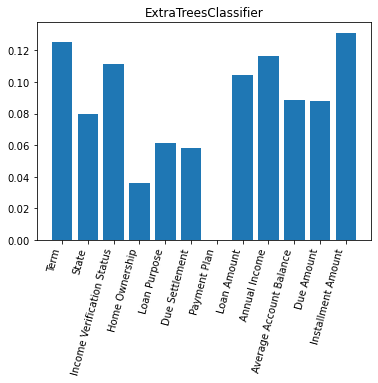

(1515, 7)
[0.13106396 0.05708709 0.10976785 0.01775874 0.04117851 0.05183957
 0.         0.10367605 0.14061022 0.09052378 0.09264267 0.16385156]


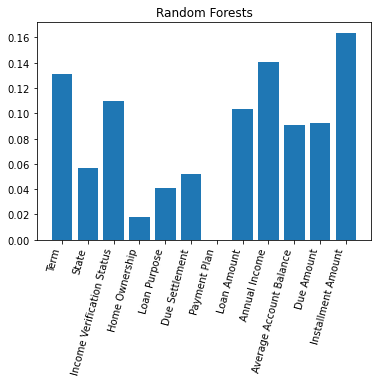

[0.28004554 0.02531567 0.1951377  0.02139899 0.0729692  0.12963468
 0.         0.07445563 0.05931464 0.03388833 0.03387658 0.07396302]


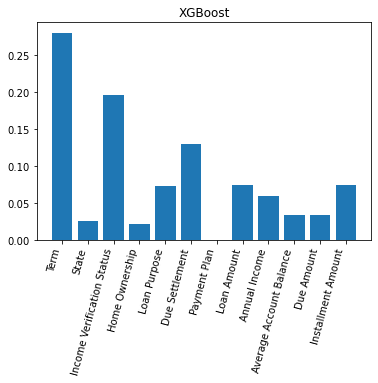

In [7]:
# Scikit-Learn官網 Feature Importance 範例
print(x_train.shape)
clf = ExtraTreesClassifier(n_estimators=500)
clf = clf.fit(x_train, y_train)
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(x_train)
print(clf.feature_importances_)
plt.bar(data.columns[:-1], clf.feature_importances_)
plt.xticks(rotation=75, ha='right')
plt.title('ExtraTreesClassifier')
plt.show()
print(X_new.shape)

print('==================================')

# Feature Importance of Random Forests
print(model2.feature_importances_)
plt.bar(data.columns[:-1], model2.feature_importances_)
plt.xticks(rotation=75, ha='right')
plt.title('Random Forests')
plt.show()

print('==================================')

# Feature Importance of XGBoost
print(model3.feature_importances_)
plt.bar(data.columns[:-1], model3.feature_importances_)
plt.xticks(rotation=75, ha='right')
plt.title('XGBoost')
plt.show()

# 小結:
不同的樹狀模型有其偏好的Features Importances

總體來說:

* Term
* State
* Income Verification Status
* Loan Amount, Annual Income
* Average Account Balance
* Installment Account

是公認較為重要的特徵值


其中，而以XGBoost模型為例:
    
其特別重視 Term 與 Income Verification Status

然而我並未能找到背後合理的解釋性，且 EDA(資料觀察) 的結果也顯示，上述7個特徵與核貸率皆有其重要性與關聯性

故我較傾向選擇 VotingClassifier 來分散Overfitting的風險

In [8]:
# Predict and Output
# y_test_pred = model1.predict(test_data.iloc[:, :-1].values)
# y_test_pred = model2.predict(test_data.iloc[:, :-1].values)
# y_test_pred = model3.predict(test_data.iloc[:, :-1].values) # XGB, The powerful one
y_test_pred = eclf.predict(test_data.iloc[:, :-1].values) 

submission_df = pd.concat([test_index, pd.DataFrame(y_test_pred, columns=['Approve Loan'])], axis=1, sort=True)
submission_df.to_csv('submission.csv', index=False)
submission_df.head()

,id,Approve Loan
0,1601,0
1,1959,1
2,1174,1
3,634,0
4,2508,0


# 參考文獻

[Machine learning project in python to predict loan approval (Part 6 of 6) (Very Simple)](https://copycoding.com/d/machine-learning-project-in-python-to-predict-loan-approval-prediction-part-6-of-6-)

[**Loan Approval Prediction:**](https://www.kaggle.com/ajaymanwani/loan-approval-prediction)

[怎麼做一個好的特徵選擇(使用Python)](https://medium.com/@jacky308082/%E6%80%8E%E9%BA%BC%E5%81%9A%E4%B8%80%E5%80%8B%E5%A5%BD%E7%9A%84%E7%89%B9%E5%BE%B5%E9%81%B8%E6%93%87-%E4%BD%BF%E7%94%A8python-part-1-d698cc15d76e)

[Tree-based feature selection](https://scikit-learn.org/stable/modules/feature_selection.html)

[Loan Data EDA (+ simple model)](https://www.kaggle.com/netzone/loan-data-eda-simple-model)

[**Architectshwet/Loan-prediction-using-Machine-Learning-and-Python**](https://github.com/Architectshwet/Loan-prediction-using-Machine-Learning-and-Python)

[機器學習之XGBoost分類器XGBClassifier-- xgb使用sklearn介面](https://www.itread01.com/content/1545533828.html)

[Hyperparameter Tuning the Random Forest in Python](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)

[scikit-learn随机森林调参小结](https://www.cnblogs.com/pinard/p/6160412.html)

[**xgboost入门与实战（原理篇）**](https://blog.csdn.net/sb19931201/article/details/52557382)